In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
data_dir = "/content/drive/My Drive/Assignment 5 Dataset"

In [6]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)
testing_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,num_workers= 4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers= 4)
testingloader = torch.utils.data.DataLoader(testing_data, batch_size=64, shuffle=True, num_workers= 4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


### **Helper functions**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


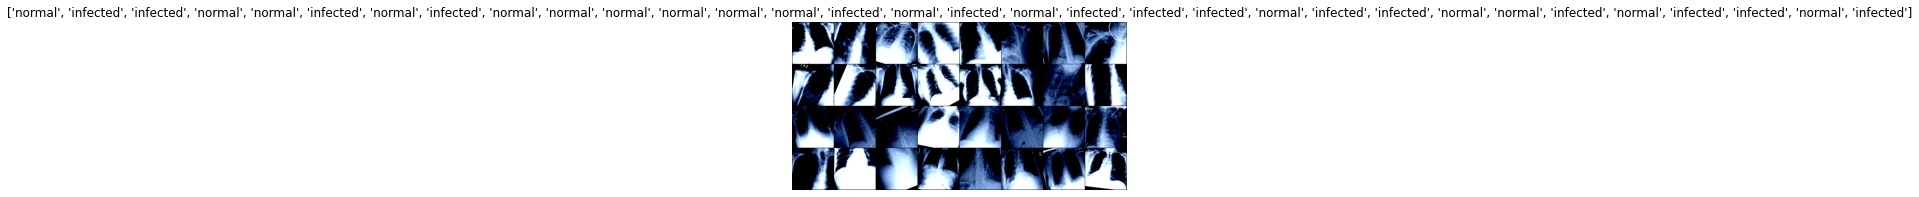

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [0]:
def trainable_params(model_):
  # Find total parameters and trainable parameters
  total_params = sum(p.numel() for p in model_.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(
      p.numel() for p in model_.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')

In [0]:
def freeze_network(model_):
  # Freeze model weights
  for param in model_.parameters():
    param.requires_grad = False
  
  return model_

In [0]:
def train_model(model_,epochs,optimizer,model_dir,model_name,type_):


  #if you have gpu then you need to convert the network and data to cuda
  #the easiest way is to first check for device and then convert network and data to device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print (device)
  model_.to(device)

  best_loss = 10000

  losses_train,losses_valid,accuracy_train,accuracy_valid = [],[],[],[]
  for epoch in range(epochs):  # loop over the dataset multiple times


      model_.train(True)
      running_loss = 0.0
      running_corrects = 0 
      print ("Training")
      batch = 0
      for inputs,labels in trainloader: 
          # get the inputs
          # inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          print (batch)
          batch += 1
          # zero the parameter gradients
          optimizer.zero_grad()
          # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
          # because PyTorch accumulates the gradients on subsequent backward passes. 
          # This is convenient while training RNNs. 
          # So, the default action is to accumulate the gradients on every loss.backward() call

          # forward + backward + optimize
          outputs = model_(inputs)               #----> forward pass
          loss = criterion(outputs, labels)   #----> compute loss
          loss.backward()                     #----> backward pass
          optimizer.step()                    #----> weights update
          _, preds = torch.max(outputs.data, 1)
          # print statistics
          running_loss += loss.item()
          running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss / len(train_data)
      epoch_acc = running_corrects.double() /len(train_data)
      losses_train.append(epoch_loss)
      accuracy_train.append(epoch_acc)


      model_.eval()
      running_loss = 0.0
      running_corrects = 0
      print ("Validation")
      batch = 0
      for inputs,labels in testloader:
        inputs,labels = inputs.to(device),labels.to(device)
        output_val = model_(inputs)
        _, preds = torch.max(output_val, 1)
        loss = criterion(output_val, labels)
        print (batch)
        batch += 1
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
      epoch_loss_valid = running_loss/len(test_data)
      epoch_acc_valid = running_corrects.double()/len(test_data)
      losses_valid.append(epoch_loss_valid)
      accuracy_valid.append(epoch_acc_valid)

      print ("Epoch {}".format(epoch))
      print('{} Loss: {:.4f} Acc: {:.4f}'.format('Training', epoch_loss, epoch_acc))
      print('{} Loss: {:.4f} Acc: {:.4f}'.format('Validation', epoch_loss_valid, epoch_acc_valid))

      if (epoch_loss < best_loss):
        print ("saving")
        torch.save(model_, model_dir+model_name+'_'+type_+'Only.pth')
      np.save(model_dir+model_name+'_'+type_+"metrics.txt",[losses_train,losses_valid,accuracy_train,accuracy_valid])



  print('Finished Training')

### **Task 1 - a) Finetuning FC layers for VGG16**

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

In [0]:
vgg16 = freeze_network(vgg16)

#### Removing last FC layer and add two custom layers!

In [0]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 160),nn.Linear(160, 2)])
# vgg16.classifier[6] = nn.Linear(num_features, 2)
vgg16.classifier = nn.Sequential(*features)

In [0]:
Epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)
model_dir = "/content/drive/My Drive/model_pytorch/v1/"

train_model(vgg16,Epochs,optimizer,model_dir,"vgg16","fc")

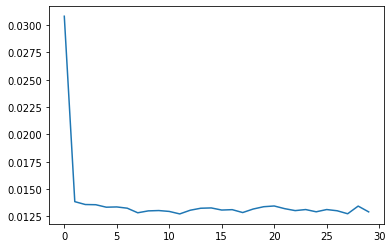

In [0]:
plt.plot(losses_train)

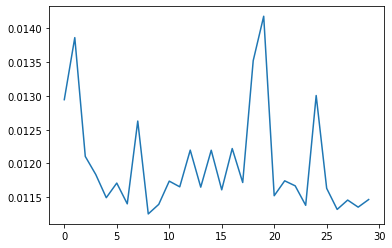

In [0]:
plt.plot(losses_valid)

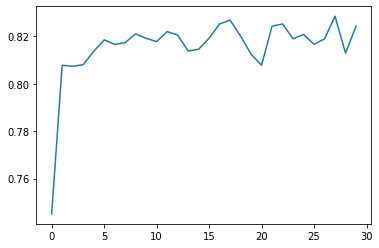

In [0]:
plt.plot(accuracy_train)

(0.5, 0.9)

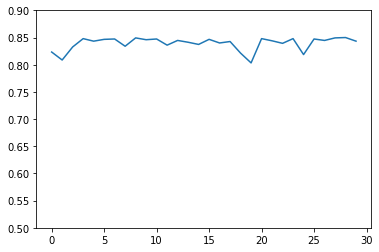

In [0]:
plt.plot(accuracy_valid)
plt.ylim(0.5,0.9)

### **Task 1 - b) Finetuning FC layers for Res18**


In [8]:
res18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
res18 = freeze_network(res18)

### Removing last FC layer and add two custom layers!

In [0]:
num_features = res18.fc.in_features
res18.fc = nn.Sequential(*[nn.Linear(num_features,160), nn.ReLU(), nn.Linear(160,2)])

In [0]:
Epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res18.parameters(), lr=0.001)

train_model(res18,Epochs,optimizer,model_dir,"res18","fc")

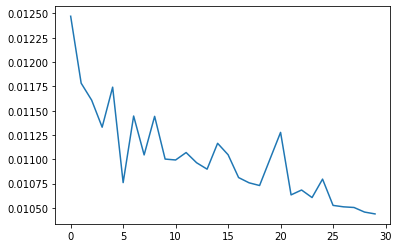

In [0]:
plt.plot(losses_train)

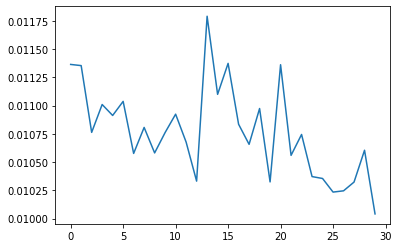

In [0]:
plt.plot(losses_valid)

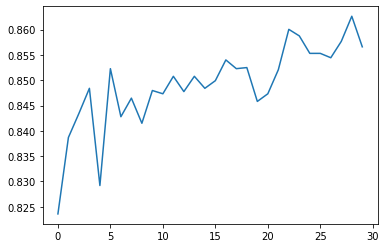

In [0]:
plt.plot(accuracy_train)

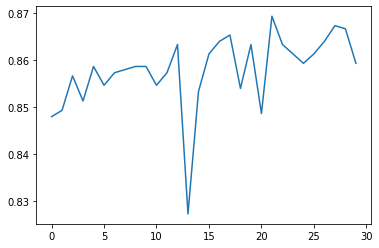

In [0]:
plt.plot(accuracy_valid)

##  **Task 2 - a1) Fine tuning conv layers in VGG 16**

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
vgg16 = freeze_network(vgg16)

In [0]:
trainable_params(vgg16)

In [0]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 160),nn.Linear(160, 2)])
# vgg16.classifier[6] = nn.Linear(num_features, 2)
vgg16.classifier = nn.Sequential(*features)

In [0]:
for params_ in vgg16.classifier.parameters():
  params_.requires_grad = True

In [0]:
for p in vgg16.features[28].parameters():
  p.requires_grad = True

In [0]:
for n,m in vgg16.named_parameters():
  print (n)
  print (m.requires_grad)

In [0]:
Epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)
model_dir = "/content/drive/My Drive/model_pytorch/v1/"

train_model(vgg16,Epochs,optimizer,model_dir,"vgg16","convOnly")

### **Task 2 - a2) Fine tuning entire network of VGG 16**

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

In [0]:
trainable_params(vgg16)

134,916,386 total parameters.
134,916,386 training parameters.


In [0]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 160),nn.Linear(160, 2)])
# vgg16.classifier[6] = nn.Linear(num_features, 2)
vgg16.classifier = nn.Sequential(*features)

In [0]:
Epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)
model_dir = "/content/drive/My Drive/model_pytorch/v1/"

train_model(vgg16,Epochs,optimizer,model_dir,"vgg16","entire")

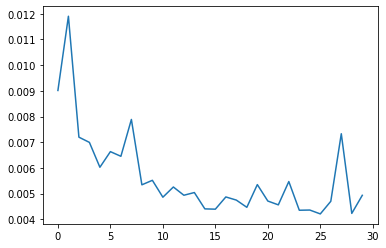

In [0]:
plt.plot(losses_valid)

### **Task 2 - b) Fine tuning entire network of Res 18**

In [12]:
res18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
num_features = res18.fc.in_features
res18.fc = nn.Sequential(*[nn.Linear(num_features,160), nn.ReLU(), nn.Linear(160,2)])

In [14]:
trainable_params(res18)

11,258,914 total parameters.
11,258,914 training parameters.


In [0]:
Epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res18.parameters(), lr=0.001)
model_dir = "/content/drive/My Drive/model_pytorch/v1/"

train_model(res18,Epochs,optimizer,model_dir,"res18","entire")

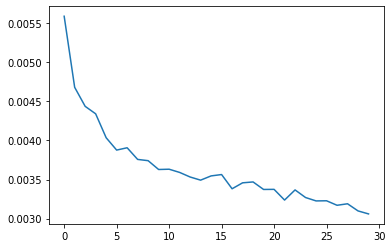

In [15]:
plt.plot(losses_train)

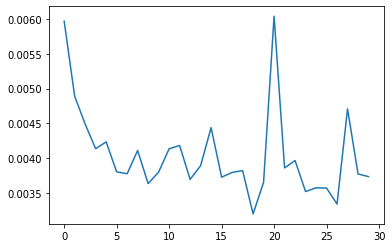

In [16]:
plt.plot(losses_valid)

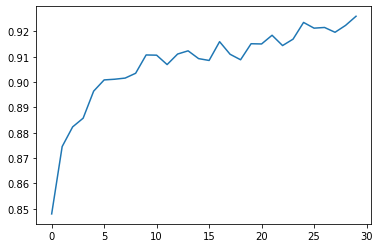

In [17]:
plt.plot(accuracy_train)

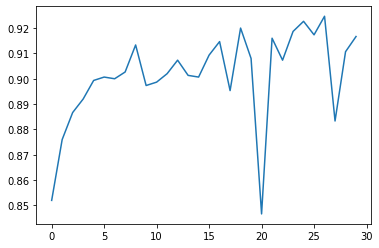

In [18]:
plt.plot(accuracy_valid)

### Code for confusion matrix calculation

In [63]:
nb_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        print (i)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
tensor([[455., 160.],
        [ 99., 786.]])
